In [13]:
i=5

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import csv
import pickle
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/mgander/Atlantic/notebooks/Kinobeads")
import fitter
from fitter import process_dfs
cols = ['-pec50', 'slope', 'front', 'back', 'fold_change', 'auc', 'rmse', 'r2', 'M1_noise', 'p_err_0', 'p_err_1', 'p_err_2', 'p_err_3', 
     'p_err_4', 'm0_rmse', 'm1_likelihood', 'm0_likelihood', 'f_statistic', 'p_value']

Path='/home/mgander/Atlantic/data/Viability/'

M = pd.read_pickle(f'{Path}/M_all_all.pkl')
sources = sorted(set(M['Source']))

df = M[M['Source']==sources[i]].copy()

df['log_dose']=np.log10(df['Dose'])

df['key'] = df['Cello']+'_'+df['PubChem_CID']
df['key'] = df['key'].astype('category')

keys=sorted(set(df['key']))

def do_batch(batch):
    dfb = df[df['key'].isin(batch)].copy()
    dfb['key'] = list(dfb['key'])
    dfb['key'] = dfb['key'].astype('category')
    all_dfs = [group for _, group in dfb.groupby('key')]

    from joblib import Parallel, delayed
    from tqdm import tqdm
    
    # Initialize lists to store results
    lks = []
    ress = []
    
    # Define the number of jobs
    num_jobs = 25  # Set to -1 to use all available cores
    
    # Parallel processing
    results = Parallel(n_jobs=num_jobs)(delayed(process_dfs)(dfs) for dfs in all_dfs)
    
    # Process the results
    for key, res in results:
        lks.append(key)
        ress.append(res)
    return(lks, ress)


lks, ress = [], []

batchsize = 10**4

ks = int(np.ceil(len(keys) / batchsize))

for k in tqdm(range(ks)):
    batch = keys[k*batchsize:(k+1)*batchsize]
    a,b = do_batch(batch)
    lks.append(a)
    ress.append(b)
lks2=[a for b in lks for a in b]
ress2=[a for b in ress for a in b]

dff=pd.DataFrame(data=np.array(ress2), index=lks2, columns=cols)
dff.to_pickle(f'{Path}/dff_inhouse.pkl')
dff

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.31s/it]


In [16]:
(~np.isfinite(dff)).sum()

-pec50               0
slope                0
front                0
back                 0
fold_change       3448
auc                  0
rmse                 0
r2               10114
M1_noise             0
p_err_0              0
p_err_1              0
p_err_2              0
p_err_3              0
p_err_4              0
m0_rmse              0
m1_likelihood    10114
m0_likelihood    10114
f_statistic          0
p_value              0
dtype: int64

In [22]:
dff['lgp']=-np.log10(dff['p_value'])

<Axes: xlabel='lgp', ylabel='Count'>

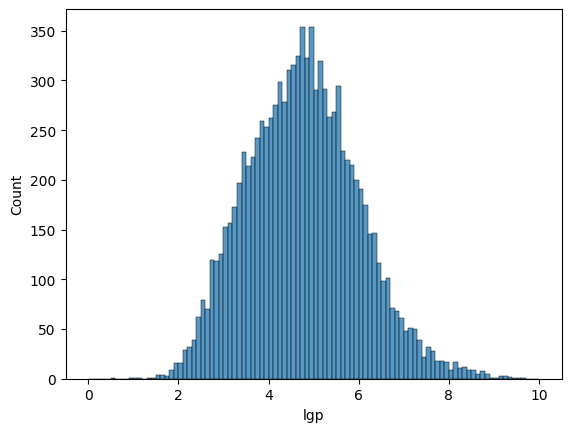

In [24]:
sns.histplot(data=dff, x='lgp', bins=np.linspace(0,10,101))